# motion_repr_learning/ae/utils/flags.py

In [32]:
"""
This module contrains all the flags for the motion representation learning repository
"""
from __future__ import division
import os
from os.path import join as pjoin

import tensorflow as tf

os.environ['HOME'] = 'H:\\minjae\\Trying Obama Dataset'

# Modify this function to set your home directory for this repo
def home_out(path):
    return pjoin(os.environ['HOME'], 'tmp', 'MoCap', path)

flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')# added, no error


"""  							Fine-tuning Parameters 				"""

#                       Flags about the sequence processing

flags.DEFINE_integer('chunk_length', 1, 'Length of the chunks, for the data processing.')

#                               Flags about training
flags.DEFINE_float('learning_rate', 0.0001,
                   'learning rate for training .')
flags.DEFINE_float('pretraining_learning_rate', 0.001 ,
                   'learning rate for training .')

flags.DEFINE_float('variance_of_noise', 0.05, 'Coefficient for the gaussian noise '
                                              'added to every point in input during the training')

flags.DEFINE_boolean('pretrain', False,' Whether we pretrain the model in a layerwise way')
flags.DEFINE_boolean('restore', False,' Whether we restore the model from the checkpoint')

flags.DEFINE_boolean('evaluate', False, ' Whether we are evaluating the system')

flags.DEFINE_float('dropout', 0.9, 'Probability to keep the neuron on')

flags.DEFINE_integer('batch_size', 128,
                     'Size of the mini batch')

flags.DEFINE_integer('training_epochs', 50,
                     "Number of training epochs for pretraining layers")
flags.DEFINE_integer('pretraining_epochs', 5,
                     "Number of training epochs for pretraining layers")

flags.DEFINE_float('weight_decay', 0.5, ' Whether we apply weight decay')

flags.DEFINE_boolean('early_stopping', True, ' Whether we do early stopping')
flags.DEFINE_float('delta_for_early_stopping', 0.5, 'How much worst the results must get in order'
                                                    ' for training to be terminated.'
                                                    ' 0.05 mean 5% worst than best we had.')

#                       Network Architecture Specific Flags
# flags.DEFINE_integer('frame_size', 384, 'Dimensionality of the input for a single frame')
flags.DEFINE_integer('frame_size', 204, 'Dimensionality of the input for a single frame')

flags.DEFINE_integer("num_hidden_layers", 1, "Number of hidden layers")
flags.DEFINE_integer("middle_layer", 1, "Number of hidden layers")

# flags.DEFINE_integer('layer1_width', 312, 'Number of units in each hidden layer ')
flags.DEFINE_integer('layer1_width', 180, 'Number of units in each hidden layer ')
# 90, 120, 150, 180, 


# flags.DEFINE_integer('layer2_width', 248, 'Number of units in each hidden layer ')
# flags.DEFINE_integer('layer3_width', 312, 'Number of units in each hidden layer ')

#                           Constants

flags.DEFINE_integer('seed', 123456, 'Random seed')

flags.DEFINE_string('summary_dir', home_out('summaries_exp'),
                    'Directory to put the summary data')

flags.DEFINE_string('chkpt_dir', home_out('chkpts_exp'),
                    'Directory to put the model checkpoints')

flags.DEFINE_string('results_file', home_out('results.txt'),
                    'File to put the experimental results')


'\nThis module contrains all the flags for the motion representation learning repository\n'

DuplicateFlagError: The flag 'f' is defined twice. First from C:\Users\Wen\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py, Second from C:\Users\Wen\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py.  Description from first occurrence: kernel

# motion_repr_learning/ae/train.py

In [33]:
import time
class DataInfo(object):
    """Information about the datasets

     Will be passed to the network for creating corresponding variables in the graph
    """

    def __init__(self, data_sigma, train_shape, eval_shape, max_val, mean_pose):
        """DataInfo initializer

        Args:
          data_sigma:   variance in the dataset
          train_shape:  dimensionality of the train dataset
          eval_shape:   dimensionality of the evaluation dataset
        """
        self.data_sigma = data_sigma
        self.train_shape = train_shape
        self.eval_shape = eval_shape
        self.max_val = max_val
        self.mean_pose = mean_pose


###############################################
####                                    #######
####              TRAIN                 #######
####                                    #######
###############################################


def learning(data, data_info, just_restore=False):
    """ Training of the network

    Args:
        data:           dataset to train on
        data_info :     meta information about this dataset (such as variance, mean pose, etc.)
                        it is an object from the class DataInfo (defined at the top of this file)
        just_restore:   weather we are going to only restore the model from the checkpoint
                        or are we going to train it as well

    Returns:
        nn:             Neural Network trained on a data provided
    """

    test = False
    debug = False

    with tf.Graph().as_default():

        tf.set_random_seed(FLAGS.seed)

        start_time = time.time()

        # Read the flags
        variance = FLAGS.variance_of_noise
        num_hidden = FLAGS.num_hidden_layers # 1
        dropout = FLAGS.dropout
        learning_rate = FLAGS.learning_rate
        batch_size = FLAGS.batch_size

        hidden_shapes = [FLAGS.layer1_width
                         for j in range(num_hidden)]
        print("hidden_shapes:", hidden_shapes)
        
        # Check if the flags makes sence
        if dropout < 0 or variance < 0:
            print('ERROR! Have got negative values in the flags!')
            exit(1)

        # Allow TensorFlow to change device allocation when needed
        config = tf.ConfigProto(allow_soft_placement=True)  # log_device_placement=True)
        # Adjust configuration so that multiple executions are possible
        config.gpu_options.allow_growth = True

        # Start a session
        sess = tf.Session(config=config)

        if debug:
            sess = tf_debug.TensorBoardDebugWrapperSession(sess, "taras-All-Series:6064")

        # Create a neural network
        shape = [FLAGS.frame_size * FLAGS.chunk_length] + hidden_shapes + [
            FLAGS.frame_size * FLAGS.chunk_length]
        print("FLAGS.frame_size:", FLAGS.frame_size)
        print("shape:", shape)
        nn = DAE(shape, sess, variance, data_info)
        print('\nDAE with the following shape was created : ', shape)

        # Initialize input_producer
        sess.run(tf.local_variables_initializer())

        max_val = nn.max_val

        with tf.variable_scope("Train"):

            ##############        DEFINE  Optimizer and training OPERATOR      ############

            # Define the optimizer
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

            # Do gradient clipping
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(nn._loss, tvars), 1e12)
            train_op = optimizer.apply_gradients(zip(grads, tvars),
                                                 global_step=tf.train.get_or_create_global_step())

            # Prepare for making a summary for TensorBoard
            train_error = tf.placeholder(dtype=tf.float32, shape=(), name='train_error')
            eval_error = tf.placeholder(dtype=tf.float32, shape=(), name='eval_error')

            train_summary_op = tf.summary.scalar('Train_error', train_error)
            eval_summary_op = tf.summary.scalar('Validation_error', eval_error)

            summary_dir = FLAGS.summary_dir
            summary_writer = tf.summary.FileWriter(summary_dir, graph=tf.get_default_graph())

            num_batches = int(data.train.num_sequences / batch_size)

            # Initialize the part of the graph with the input data
            sess.run(nn._train_data.initializer,
                     feed_dict={nn._train_data_initializer: data.train.sequences})
            sess.run(nn._valid_data.initializer,
                     feed_dict={nn._valid_data_initializer: data.test.sequences})

            # Start input enqueue threads.
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)

            if FLAGS.pretrain:
                layers_amount = len(nn.shape) - 2

                # create an optimizers
                pretrain_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

                # Make an array of the trainers for all the layers
                trainers = [pretrain_optimizer.minimize(
                    loss_reconstruction(nn.run_less_layers(nn._input_, i+1),
                                           nn.run_less_layers(nn._input_, i+1, is_target=True),
                                           max_val, pretrain=True),
                    global_step=tf.train.get_or_create_global_step(),
                    name='Layer_wise_optimizer_'+str(i))
                            for i in range(layers_amount)]

                # Initialize all the variables
                sess.run(tf.global_variables_initializer())

            else:
                print("Initializing variables ...\n")
                sess.run(tf.global_variables_initializer())

            # Create a saver
            saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)
            chkpt_file = FLAGS.chkpt_dir + '/chkpt-final'

            # restore model, if needed
            if FLAGS.restore:
                saver.restore(sess, chkpt_file)
                print("Model restored from the file " + str(chkpt_file) + '.')

            if just_restore:
                coord.request_stop()
                return nn

            # A few initialization for the early stopping
            delta = FLAGS.delta_for_early_stopping  # error tolerance for early stopping
            best_error = 10000
            num_valid_batches = int(data.test.num_sequences / batch_size)

            try:  # running enqueue threads.

                # Pretrain
                if FLAGS.pretrain:
                    layerwise_pretrain(nn, trainers, layers_amount, num_batches)

                # Train the whole network jointly
                step = 0
                print('\nFinetune the whole network on ', num_batches, ' batches with ', batch_size,
                      ' training examples in each for', FLAGS.training_epochs, ' epochs...')
                print("")
                print(" ______________ ______")
                print("|     Epoch    | RMSE |")
                print("|------------  |------|")

                while not coord.should_stop():
                    _, train_error_ = sess.run([train_op, nn._reconstruction_loss], feed_dict={})

                    if step % num_batches == 0:
                        epoch = step * 1.0 / num_batches

                        train_summary = sess.run(train_summary_op, feed_dict={
                            train_error: np.sqrt(train_error_)})

                        # Print results of screen
                        epoch_str = "| {0:3.0f} ".format(epoch)[:5]
                        perc_str = "({0:3.2f}".format(epoch*100.0 / FLAGS.training_epochs)[:5]
                        error_str = "%) |{0:5.2f}".format(train_error_)[:10] + "|"
                        print(epoch_str, perc_str, error_str)

                        if epoch % 5 == 0 and test:

                            rmse = test(nn, FLAGS.data_dir + '/test_1.binary')
                            print("\nOur RMSE for the first test sequence is : ", rmse)

                            rmse = test(nn, FLAGS.data_dir + '/test_2.binary')
                            print("\nOur RMSE for the second test sequenceis : ", rmse)

                        if epoch > 0:
                            summary_writer.add_summary(train_summary, step)

                            # Evaluate on the validation sequences
                            error_sum = 0
                            for valid_batch in range(num_valid_batches):
                                curr_err = sess.run([nn._valid_loss], feed_dict={})
                                error_sum += curr_err[0]
                            new_error = error_sum / (num_valid_batches)
                            eval_sum = sess.run(eval_summary_op,
                                                feed_dict={eval_error: np.sqrt(new_error)})
                            summary_writer.add_summary(eval_sum, step)

                            # Early stopping
                            if FLAGS.early_stopping:
                                if (new_error - best_error) / best_error > delta:
                                    print('After ' + str(step) + ' steps started overfitting')
                                    break
                                if new_error < best_error:
                                    best_error = new_error

                                    # Saver for the model
                                    save_path = saver.save(sess, chkpt_file)

                            if epoch % 5 == 0:
                                # Save for the model
                                save_path = saver.save(sess, chkpt_file)
                                print('Done training for %d epochs' % (epoch))
                                print("The model was saved in file: %s" % save_path)

                    step += 1

            except tf.errors.OutOfRangeError:
                if not FLAGS.early_stopping:
                    # Save the model
                    save_path = saver.save(sess, chkpt_file)
                print('Done training for %d epochs, %d steps.' % (FLAGS.training_epochs, step))
                print("The final model was saved in file: %s" % save_path)
            finally:
                # When done, ask the threads to stop.
                coord.request_stop()

            # Wait for threads to finish.
            coord.join(threads)

        duration = (time.time() - start_time) / 60  # in minutes, instead of seconds

        print("The training was running for %.3f  min" % (duration))

        return nn
def decode(nn, represent_vec):
    """ Decoding a representation from AE (AutoEncoder)

      Args:
          nn:              trained AutoEncoder
          represent_vec:   input sequence to be encoded

      Returns:
          output_seq:  vector of encoding
    """

    print("Decoding ...")

    with nn.session.graph.as_default() as sess:

        # Obtain important constants

        sess = nn.session
        mean_pose = nn.mean_pose
        max_val = nn.max_val

        #                    GET THE DATA

        # Check if we can cut sequence into the chunks of length ae.sequence_length
        if represent_vec.shape[0] < nn.sequence_length:
            mupliplication_factor = int(nn.batch_size * nn.sequence_length /
                                        represent_vec.shape[0]) + 1

            # Pad the sequence with itself in order to fill the sequence completely
            represent_vec = np.tile(represent_vec, (mupliplication_factor, 1))
            print("Test sequence was way too short, so we padded it with itself!")

        # Split it into chunks
        all_chunks = represent_vec

        if all_chunks.shape[0] < nn.batch_size:
            mupliplication_factor = int(nn.batch_size / all_chunks.shape[0]) + 1

            # Pad the sequence with itself in order to fill the batch completely
            all_chunks = np.tile(all_chunks, (mupliplication_factor, 1))

        # Batch those chunks
        batches = np.array([all_chunks[i:i + nn.batch_size, :]
                            for i in range(0, len(all_chunks) - nn.batch_size + 1, nn.batch_size)])

        numb_of_batches = batches.shape[0]

        #                    RUN THE NETWORK

        output_batches = np.array([])

        # Go over all batches one by one
        for batch_numb in range(numb_of_batches):
            output_batch = sess.run([nn._decode],
                                    feed_dict={nn._representation: batches[batch_numb]})
            output_batches = np.append(output_batches, output_batch, axis=0) \
                if output_batches.size else np.array(output_batch)

        # Postprocess...
        output_vec = np.reshape(output_batches, (-1, FLAGS.chunk_length * FLAGS.frame_size))

        # Convert back to original values
        reconstructed = convert_back_to_AU(output_vec, max_val, mean_pose)
        print("reconstructed:", reconstructed)
        return reconstructed



# motion_repr_learning/ae/DAE.py

In [34]:
def add_noise(x, variance_multiplier, sigma):
    """
           Add Gaussian noise to the data
           Args:
               x                   - input vector
               variance_multiplier - coefficient to multiple variance of the noise on
               sigma               - variance of the dataset
           Returns:
               x - output vector, noisy data
    """
    eps = 1e-15
    noise = tf.random_normal(x.shape, 0.0, stddev=np.multiply(sigma, variance_multiplier) + eps)
    x = x + noise
    return x

def loss_reconstruction(output, target, max_vals, pretrain=False):
    """ Reconstruction error. Square of the RMSE

    Args:
      output:    tensor of net output
      target:    tensor of net we are trying to reconstruct
      max_vals:  array of absolute maximal values in the dataset,
                is used for scaling an error to the original space
      pretrain:  wether we are using it during the pretraining phase
    Returns:
      Scalar tensor of mean squared Eucledean distance
    """
    with tf.name_scope("reconstruction_loss"):
        net_output_tf = tf.convert_to_tensor(tf.cast(output, tf.float32), name='input')
        target_tf = tf.convert_to_tensor(tf.cast(target, tf.float32), name='target')

        # Euclidean distance between net_output_tf,target_tf
        error = tf.subtract(net_output_tf, target_tf)

        if not pretrain:
            # Convert it back from the [-1,1] to original values
            error_scaled = tf.multiply(error, max_vals[np.newaxis, :] + 1e-15)
        else:
            error_scaled = error

        squared_error = tf.reduce_mean(tf.square(error_scaled, name="square"), name="averaging")
    return squared_error

class DAE:
    """ Denoising Autoendoder (DAE)

    More details about the network in the original paper:
    http://www.jmlr.org/papers/v11/vincent10a.html

    The user specifies the structure of this network
    by specifying number of inputs, the number of hidden
    units for each layer and the number of final outputs.
    All this information is set in the utils/flags.py file.

    The number of input neurons is defined as a frame_size*chunk_length,
    since it will take a time-window as an input

    """

    def __init__(self, shape, sess, variance_coef, data_info):
        """DAE initializer

        Args:
          shape:          list of ints specifying
                          num input, hidden1 units,...hidden_n units, num outputs
          sess:           tensorflow session object to use
          varience_coef:  multiplicative factor for the variance of noise wrt the variance of data
          data_info:      key information about the dataset
        """

        self.__shape = shape  # [input_dim,hidden1_dim,...,hidden_n_dim,output_dim]
        self.__variables = {}
        self.__sess = sess

        self.num_hidden_layers = np.size(shape) - 2
#         print('self.num_hidden_layers:',self.num_hidden_layers)
        self.batch_size = FLAGS.batch_size
        self.sequence_length = FLAGS.chunk_length

        self.scaling_factor = 1

	    # maximal value and mean pose in the dataset (used for scaling it to interval [-1,1] and back)
        self.max_val = data_info.max_val
        self.mean_pose = data_info.mean_pose


        #################### Add the DATASETS to the GRAPH ###############

        #### 1 - TRAIN ###
        self._train_data_initializer = tf.placeholder(dtype=tf.float32,
                                                      shape=data_info.train_shape)
        self._train_data = tf.Variable(self._train_data_initializer,
                                       trainable=False, collections=[], name='Train_data')
        train_epochs = FLAGS.training_epochs + FLAGS.pretraining_epochs * FLAGS.num_hidden_layers
        train_frames = tf.train.slice_input_producer([self._train_data], num_epochs=train_epochs)
        self._train_batch = tf.train.shuffle_batch(train_frames,
                                                   batch_size=FLAGS.batch_size, capacity=5000,
                                                   min_after_dequeue=1000, name='Train_batch')
        print("data_info.train_shape:", data_info.train_shape)
        print("self._train_data:", self._train_data)
        print("train_epochs:", train_epochs)
        print("train_frames:", train_frames)
        
        #### 2 - VALIDATE, can be used as TEST ###
        # When optimizing - this dataset stores as a validation dataset,
        # when testing - this dataset stores a test dataset
        self._valid_data_initializer = tf.placeholder(dtype=tf.float32,
                                                      shape=data_info.eval_shape)
        self._valid_data = tf.Variable(self._valid_data_initializer,
                                       trainable=False, collections=[], name='Valid_data')
        valid_frames = tf.train.slice_input_producer([self._valid_data],
                                                     num_epochs=FLAGS.training_epochs)
        self._valid_batch = tf.train.shuffle_batch(valid_frames,
                                                   batch_size=FLAGS.batch_size, capacity=5000,
                                                   min_after_dequeue=1000, name='Valid_batch')

        if FLAGS.weight_decay is not None:
            print('\nWe apply weight decay')

        ### Specify tensorflow setup  ###
        with sess.graph.as_default():

            ##############        SETUP VARIABLES       ######################

            with tf.variable_scope("AE_Variables"):

                for i in range(self.num_hidden_layers + 1):  # go over layers

                    # create variables for matrices and biases for each layer
                    self._create_variables(i, FLAGS.weight_decay)

                ##############        DEFINE THE NETWORK     ##################

                ''' 1 - Setup network for TRAINing '''
                # Input noisy data and reconstruct the original one
                # as in Denoising AutoEncoder                
                self._input_ = add_noise(self._train_batch, variance_coef, data_info.data_sigma)
                self._target_ = self._train_batch
                # Define output and loss for the training data
                self._output, _, _ = self.construct_graph(self._input_, FLAGS.dropout)
                self._reconstruction_loss = loss_reconstruction(self._output,
                                                                self._target_, self.max_val)
                tf.add_to_collection('losses', self._reconstruction_loss)  # add weight decay loses
                self._loss = tf.add_n(tf.get_collection('losses'), name='total_loss')

                ''' 2 - Setup network for TESTing '''
                self._valid_input_ = self._valid_batch
                self._valid_target_ = self._valid_batch

                # Define output (no dropout)
                self._valid_output, self._encode, self._decode = \
                    self.construct_graph(self._valid_input_, 1)

                # Define loss
                self._valid_loss = loss_reconstruction(self._valid_output,
                                                       self._valid_target_, self.max_val)
    @property
    def session(self):
        """ Interface for the session"""
        return self.__sess

    @property
    def shape(self):
        """ Interface for the shape"""
        return self.__shape

    # Make more comfortable interface to the network weights

    def _w(self, n, suffix=""):
        return self["matrix"+str(n)+suffix]

    def _b(self, n, suffix=""):
        return self["bias"+str(n)+suffix]

    @staticmethod
    def _feedforward(x, w, b):
        """
        Traditional feedforward layer: multiply on weight matrix, add bias vector
         and apply activation function

        Args:
            x: input ( usually - batch of vectors)
            w: matrix to be multiplied on
            b: bias to be added

        Returns:
            y: result of applying this feedforward layer
        """

        y = tf.tanh(tf.nn.bias_add(tf.matmul(x, w), b))
        return y

    def construct_graph(self, input_seq_pl, dropout):

        """ Construct a TensorFlow graph for the AutoEncoding network

        Args:
          input_seq_pl:     tf placeholder for input data: size [batch_size, sequence_length * DoF]
          dropout:          how much of the input neurons will be activated, value in range [0,1]
        Returns:
          output:           output tensor: result of running input placeholder through the network
          middle_layer:     tensor which is encoding input placeholder into a representation
          decoding:         tensor which is decoding a representation back into the input vector
        """

        network_input = input_seq_pl
        print("network_input:",network_input)
        print("FLAGS.frame_size:", FLAGS.frame_size)
        curr_layer = tf.reshape(network_input, [self.batch_size,
                                                FLAGS.chunk_length * FLAGS.frame_size])

        numb_layers = self.num_hidden_layers + 1

        with tf.name_scope("Joint_run"):

            # Pass through the network
            for i in range(numb_layers):

                if i == FLAGS.middle_layer:
                    # Save middle layer
                    with tf.name_scope('middle_layer'):
                        middle_layer = tf.identity(curr_layer)

                with tf.name_scope('hidden'+str(i)):

                    # First - Apply Dropout
                    curr_layer = tf.nn.dropout(curr_layer, dropout)

                    w = self._w(i + 1)
                    b = self._b(i + 1)

                    curr_layer = self._feedforward(curr_layer, w, b)

            output = curr_layer

        # Now create a decoding network

        with tf.name_scope("Decoding"):

            layer = self._representation = tf.placeholder\
                (dtype=tf.float32, shape=middle_layer.get_shape().as_list(), name="Respres.")

            for i in range(FLAGS.middle_layer, numb_layers):

                with tf.name_scope('hidden' + str(i)):

                    # First - Apply Dropout
                    layer = tf.nn.dropout(layer, dropout)

                    w = self._w(i + 1)
                    b = self._b(i + 1)

                    layer = self._feedforward(layer, w, b)

            decoding = layer

        return output, middle_layer, decoding

    def __getitem__(self, item):
        """Get AutoEncoder tf variable

        Returns the specified variable created by this object.
        Names are weights#, biases#, biases#_out, weights#_fixed,
        biases#_fixed.

        Args:
         item: string, variables internal name
        Returns:
         Tensorflow variable
        """
        return self.__variables[item]

    def __setitem__(self, key, value):
        """Store a TensorFlow variable

        NOTE: Don't call this explicitly. It should
        be used only internally when setting up
        variables.

        Args:
          key: string, name of variable
          value: tensorflow variable
        """
        self.__variables[key] = value

    def _create_variables(self, i, wd):
        """Helper to create an initialized Variable with weight decay.
        Note that the Variable is initialized with a truncated normal distribution.
        A weight decay is added only if 'wd' is specified.
        If 'wd' is None, weight decay is not added for this Variable.

        This function was taken from the web

        Args:
          i: number of hidden layer
          wd: add L2Loss weight decay multiplied by this float.
        Returns:
          Nothing
        """

        # Initialize Train weights
        w_shape = (self.__shape[i], self.__shape[i + 1])
        a = tf.multiply(2.0, tf.sqrt(6.0 / (w_shape[0] + w_shape[1])))
        name_w = "matrix"+str(i + 1)
        self[name_w] = tf.get_variable("Variables/"+name_w,
                                       initializer=tf.random_uniform(w_shape, -1 * a, a))

        # Add weight to the loss function for weight decay
        if wd is not None:
            weight_decay = tf.multiply(tf.nn.l2_loss(self[name_w]), wd, name='wgt_'+str(i)+'_loss')
            tf.add_to_collection('losses', weight_decay)

        # Add the histogram summary
        tf.summary.histogram(name_w, self[name_w])

        # Initialize Train biases
        name_b = "bias"+str(i + 1)
        b_shape = (self.__shape[i + 1],)
        self[name_b] = tf.get_variable("Variables/"+name_b, initializer=tf.zeros(b_shape))

        if i < self.num_hidden_layers:
            # Hidden layer pretrained weights
            # which are used after pretraining before fine-tuning
            self[name_w + "_pretr"] = tf.get_variable(name="Var/" + name_w + "_pretr", initializer=
                                                      tf.random_uniform(w_shape, -1 * a, a),
                                                      trainable=False)
            # Hidden layer pretrained biases
            self[name_b + "_pretr"] = tf.get_variable("Var/"+name_b+"_pretr", trainable=False,
                                                      initializer=tf.zeros(b_shape))

            # Pretraining output training biases
            name_b_out = "bias" + str(i+1) + "_out"
            b_shape = (self.__shape[i],)
            b_init = tf.zeros(b_shape)
            self[name_b_out] = tf.get_variable(name="Var/"+name_b_out, initializer=b_init,
                                               trainable=True)

    def run_less_layers(self, input_pl, n, is_target=False):
        """Return result of a net after n layers or n-1 layer (if is_target is true)
           This function will be used for the layer-wise pretraining of the AE
        Args:
          input_pl:  TensorFlow placeholder of AE inputs
          n:         int specifying pretrain step
          is_target: bool specifying if required tensor
                      should be the target tensor
                     meaning if we should run n layers or n-1 (if is_target)
        Returns:
          Tensor giving pretraining net result or pretraining target
        """
        assert n > 0
        assert n <= self.num_hidden_layers

        last_output = input_pl

        for i in range(n - 1):
            w = self._w(i + 1, "_pretrained")
            b = self._b(i + 1, "_pretrained")

            last_output = self._feedforward(last_output, w, b)

        if is_target:
            return last_output

        last_output = self._feedforward(last_output, self._w(n), self._b(n))

        out = self._feedforward(last_output, self._w(n), self["bias" + str(n) + "_out"])

        return out


# motion_repr_learning/ae/utils/utils.py

In [35]:
""" Dataset class"""

class DataSet(object):
    '''
    A class for storing a dataset and all important information,
    which might be needed during training,
    such as batch size amount of epochs completed and so on.
    '''


    def __init__(self, sequences, batch_size):
        self._batch_size = batch_size
        self._sequences = sequences  # all the sequnces in the dataset
        self._num_sequences = sequences.shape[0]
        self._epochs_completed = 0
        self._index_in_epoch = 0

    # Make interface to the protected variables
    @property
    def sequences(self):
        return self._sequences

    @property
    def num_sequences(self):
        return self._num_sequences

class DataSets(object):
    '''
      A class for storing Train and Eval datasets and all related information,
      '''
    pass


' Dataset class'

In [36]:
def convert_back_to_AU(sequence, max_val, mean_pose):
    '''
    Convert back from the normalized values between -1 and 1 to original AU
    and unroll them into the sequence

    Args:
        sequence: sequence of the normalized values
        max_val: maximal value in the dataset
        mean_pose: mean value in the dataset

    Return:
        AU value corresponding to the batch
    '''

    # Convert it back from the [-1,1] to original values
#     reconstructed = np.multiply(sequence, max_val[np.newaxis, :] + 1e-15)
    reconstructed = np.multiply(sequence, max_val[np.newaxis, :] + 1e-8)
    
    # Add the mean pose back
    reconstructed = reconstructed + mean_pose[np.newaxis, :]

    # Unroll batches into the sequence
    reconstructed = reconstructed.reshape(-1, reconstructed.shape[-1])
    return reconstructed

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
import sys
import numpy as np
import os

# import motion_repr_learning.ae.train as tr
# from utils.utils import prepare_motion_data, DataSet, DataSets, fl


In [39]:
def create_nn(train_data, dev_data, max_val, mean_pose, restoring):
    """
    Train or restore a neural network
    Args:
     train_data:         training dataset normalized to the values [-1,1]
     dev_data:           dev dataset normalized to the values [-1,1]
     max_val:            maximal values in the dataset
     mean_pose:          mean pose of the dataset
     restoring:          weather  we are going to just restore already trained model
    Returns:
     nn: neural network, which is ready to use
    """

    # Create DataSet object

    data = DataSets()

    data.train = DataSet(train_data, FLAGS.batch_size)
    data.test = DataSet(dev_data, FLAGS.batch_size)

    # Assign variance
    data.train.sigma = np.std(train_data, axis=(0, 1))

    # Create information about the dataset
    data_info = DataInfo(data.train.sigma, data.train._sequences.shape,
                            data.test._sequences.shape, max_val, mean_pose)


    # Set "restore" flag
    FLAGS.restore = restoring
    
#     self.data_sigma = data_sigma
#     self.train_shape = train_shape
#     self.eval_shape = eval_shape
#     self.max_val = max_val
#     self.mean_pose = mean_pose

    
    print("data.train:", data.train)
    print("data_info.data_sigma:", data_info.data_sigma)
    print("data_info.train_shape:", data_info.train_shape)
    print("data_info.eval_shape:", data_info.eval_shape)
    
    # Train the network
    nn = learning(data, data_info, just_restore=restoring)

    return nn

In [40]:
# def reshape_dataset(dataset):
#     """
#     Changing the shape of the dataset array to correspond to the frame dimentionality

#     Args:
#         dataset: an array of the dataset
#     Return:
#         dataset_final: array of the dataset in a proper shape
#     """

#     amount_of_train_chunks = int(dataset.shape[0] / fl.FLAGS.chunk_length)
#     dataset_shorten = dataset[:amount_of_train_chunks * fl.FLAGS.chunk_length, :fl.FLAGS.frame_size]
#     dataset_chunks = np.reshape(dataset_shorten, (-1, fl.FLAGS.chunk_length * fl.FLAGS.frame_size))

#     # Merge all the time-frames together
#     dataset_final = np.reshape(dataset_chunks, [amount_of_train_chunks,
#                                                 fl.FLAGS.chunk_length * fl.FLAGS.frame_size])

#     return dataset_final

def prepare_motion_data(data_dir): #preprocessing
    """
    Read and preprocess the motion dataset

    Args:
        data_dir:           a directory with the dataset
    Return:
        Y_train:            an array of the training dataset
        Y_train_normalized: training dataset normalized to the values [-1,1]
        Y_test:             an array of the test dataset
        Y_test_normalized:  test dataset normalized to the values [-1,1]
        Y_dev_normalized:   dev dataset normalized to the values [-1,1]
        max_val:            maximal values in the dataset
        mean_pose:          mean pose of the dataset
    """

    # Get the data

    Y_train = np.load(data_dir + '/Y_train.npy')
    Y_dev = np.load(data_dir + '/Y_dev.npy')
    Y_test = np.load(data_dir + '/Y_test.npy')

    # Normalize dataset
    max_val = np.amax(np.absolute(Y_train), axis=(0))
    mean_pose = Y_train.mean(axis=(0))

    Y_train_centered = Y_train - mean_pose[np.newaxis, :]
    Y_dev_centered = Y_dev - mean_pose[np.newaxis, :]
    Y_test_centered = Y_test - mean_pose[np.newaxis, :]

    # Scales all values in the input_data to be between -1 and 1
    eps = 1e-8
    Y_train_normalized = np.divide(Y_train_centered, max_val[np.newaxis, :] + eps)
    Y_dev_normalized = np.divide(Y_dev_centered, max_val[np.newaxis, :] + eps)
    Y_test_normalized = np.divide(Y_test_centered, max_val[np.newaxis, :] + eps)

    # Reshape to accomodate multiple frames at each input

    if FLAGS.chunk_length > 1:
        Y_train_normalized = reshape_dataset(Y_train_normalized)
        Y_dev_normalized = reshape_dataset(Y_dev_normalized)
        Y_test_normalized = reshape_dataset(Y_test_normalized)

    # Pad max values and the mean pose, if neeeded
    if FLAGS.chunk_length > 1:
        max_val = np.tile(max_val, fl.FLAGS.chunk_length)
        mean_pose = np.tile(mean_pose, fl.FLAGS.chunk_length)


#     Some tests for flags
    if FLAGS.restore and FLAGS.pretrain:
        print('ERROR! You cannot restore and pretrain at the same time!'
              ' Please, chose one of these options')
        exit(1)

    if FLAGS.middle_layer > FLAGS.num_hidden_layers:
        print('ERROR! Middle layer cannot be more than number of hidden layers!'
              ' Please, update flags')
        exit(1)

#     Y_dev_normalized = 0
#     Y_test_normalized = 0
#     Y_test = 0
    return Y_train_normalized, Y_train, Y_test_normalized, Y_test,\
           Y_dev_normalized, max_val, mean_pose


In [41]:
def check_params():
    # Check if script get enough parameters
    if len(sys.argv)<2:
        raise ValueError('Not enough paramters! \nUsage : python '+sys.argv[0].split("/")[-1]+' DATA_DIR')

    # Check if the dataset exists
    if not os.path.exists(sys.argv[1]):
        raise ValueError('Path to the dataset ({}) does not exist!\nPlease, provide correct DATA_DIR as a script parameter'
                         ''.format(sys.argv[1]))
    # Check if the flags were set properly
    if not os.path.exists(fl.FLAGS.chkpt_dir):
        raise ValueError('Path to the checkpoints ({}) does not exit!\nChange the "chkpt_dir" flag in utils/flags.py'
                         ''.format(fl.FLAGS.chkpt_dir))


In [42]:
# Get the data
# DATA_DIR = sys.argv[1] # 'data'
DATA_DIR = 'data_3d_cord' # 'data'


train_normalized_data, train_data, test_normalized_data, test_data, dev_normalized_data, \
max_val, mean_pose = prepare_motion_data(DATA_DIR)

train_normalized_data
train_data
max_val
mean_pose

array([[-0.04872602, -0.03903012, -0.03055449, ...,  0.13191756,
         0.13260921,  0.13247271],
       [-0.05091301, -0.04070236, -0.03170657, ...,  0.13601383,
         0.1367188 ,  0.13657597],
       [-0.04927277, -0.03903012, -0.02997846, ...,  0.13140553,
         0.13209551,  0.13213077],
       ...,
       [ 0.00376168, -0.01115944, -0.03170657, ...,  0.21298942,
         0.2106914 ,  0.20804118],
       [ 0.00758891, -0.00670013, -0.02767431, ...,  0.21298942,
         0.21086264,  0.20821215],
       [ 0.01086939, -0.00391306, -0.02537016, ...,  0.21367213,
         0.21137633,  0.20889603]])

array([[-96.3, -94.2, -90.2, ..., 517.3, 516.6, 518.4],
       [-96.7, -94.5, -90.4, ..., 519.7, 519. , 520.8],
       [-96.4, -94.2, -90.1, ..., 517. , 516.3, 518.2],
       ...,
       [-86.7, -89.2, -90.4, ..., 564.8, 562.2, 562.6],
       [-86. , -88.4, -89.7, ..., 564.8, 562.3, 562.7],
       [-85.4, -87.9, -89.3, ..., 565.2, 562.6, 563.1]])

array([182.9, 179.4, 173.6, 166.4, 156.7, 143.5, 128.6, 112.1,  97.1,
       117.9, 138.1, 156.6, 171.1, 180.9, 187.6, 194. , 200. , 173.6,
       167.5, 156.6, 143.9, 131.7, 137.1, 151.4, 164. , 174.8, 180.6,
       119.5, 116.1, 112.9, 110.2, 122.6, 115.1, 108.1, 116.6, 124.4,
       156.8, 149.5, 140. , 130.9, 139. , 148.5, 139.4, 148.4, 157.4,
       163.9, 156.3, 147.5, 129.8, 121.7, 111.7, 105.7, 113.9, 126. ,
       136.5, 122.9, 109.8, 101. , 108.1, 119.1, 125.2, 110.7, 104.7,
       113. , 131.9, 111.3, 102.7, 109.6, 133.8, 112. ,  90.4,  81. ,
       103. , 118.1, 134.4, 143.6, 143.3, 137.1, 125.2, 111.7,  93.7,
        73.5,  91.1, 112.5, 134. , 143.7, 153. , 157.6, 157.2, 153.9,
       155.1, 159.4, 160.1, 156.3, 147.2, 137.4, 125.2, 114. , 102.6,
        91.7,  89.7,  88. ,  90.2,  92.3, 130. , 134.6, 135. , 131.2,
       128.9, 128.2, 132.3, 137.1, 136.9, 132.9, 130.6, 130.6,  93.6,
        84.5,  79.2,  80.6,  77.5,  80.5,  86.3,  95.4, 100.5, 102.8,
       103.4, 101. ,

array([-87.38801084, -87.19799662, -84.89574005, -80.10541045,
       -71.36207356, -59.0673463 , -45.64752799, -29.52398721,
       -11.68457267,   5.75753598,  20.97423152,  34.9430326 ,
        46.22681681,  53.64898943,  57.67137527,  60.22026031,
        61.66696651, -68.82250355, -60.62494225, -49.23058369,
       -37.03627399, -25.8432858 ,   1.05089064,  13.2305637 ,
        24.54398543,  35.53185412,  43.13366427, -11.79651297,
       -11.52091107, -11.21951626, -10.92031139, -25.88260261,
       -18.56184257, -10.97045354,  -3.32339419,   3.61480322,
       -54.88470149, -47.22006485, -38.34032072, -30.69090929,
       -38.39476946, -47.1776075 ,   6.89323472,  14.60967484,
        23.31145611,  30.34541356,  23.7977723 ,  15.31864783,
       -39.1663113 , -28.14555348, -17.43656272, -10.56997157,
        -3.02290778,   7.66841018,  17.35975702,   8.20486185,
        -2.12176839, -10.22392946, -17.80541489, -28.4835621 ,
       -34.53921908, -17.60742715, -10.59271278,  -2.89

In [43]:
train_data.shape

(45024, 204)

In [44]:
# Train an AE network
nn = create_nn(train_normalized_data, dev_normalized_data, max_val, mean_pose, restoring=False)


data.train: <__main__.DataSet object at 0x000002444110BBC8>
data_info.data_sigma: 0.19064841296470267
data_info.train_shape: (45024, 204)
data_info.eval_shape: (4333, 204)
hidden_shapes: [90]
FLAGS.frame_size: 204
shape: [204, 90, 204]
data_info.train_shape: (45024, 204)
self._train_data: <tf.Variable 'Train_data:0' shape=(45024, 204) dtype=float32_ref>
train_epochs: 55
train_frames: [<tf.Tensor 'input_producer/GatherV2:0' shape=(204,) dtype=float32>]

We apply weight decay
network_input: Tensor("AE_Variables/add:0", shape=(128, 204), dtype=float32)
FLAGS.frame_size: 204
network_input: Tensor("Valid_batch:0", shape=(128, 204), dtype=float32)
FLAGS.frame_size: 204

DAE with the following shape was created :  [204, 90, 204]
Initializing variables ...


Finetune the whole network on  351  batches with  128  training examples in each for 50  epochs...

 ______________ ______
|     Epoch    | RMSE |
|------------  |------|
|   0 (0.00 %) |31372.|
|   1 (2.00 %) |7045.8|
|   2 (4.00 %) |5336

# Encode dataset

In [45]:
def encode(nn, input_seq):
    """ Obtaining a representation from AE (AutoEncoder)

      Args:
          nn:          trained AutoEncoder
          input_seq:   input sequence to be encoded

      Returns:
          output_vec:  vector of encoding
    """

    print("Encoding ...")

    with nn.session.graph.as_default() as sess:

        # Obtain important constants

        sess = nn.session
        mean_pose = nn.mean_pose
        max_val = nn.max_val

        #                    GET THE DATA

        # get input sequnce

        Preprocess = False
        if Preprocess:
            coords_minus_mean = input_seq - mean_pose[np.newaxis, :]
            eps = 1e-15
            coords_normalized = np.divide(coords_minus_mean, max_val[np.newaxis, :] + eps)
        else:
            coords_normalized = input_seq

        # Check if we can cut sequence into the chunks of length ae.sequence_length
        if coords_normalized.shape[0] < nn.sequence_length:
            mupliplication_factor = int(nn.batch_size * nn.sequence_length /
                                        coords_normalized.shape[0]) + 1

            # Pad the sequence with itself in order to fill the sequence completely
            coords_normalized = np.tile(coords_normalized, (mupliplication_factor, 1))
            print("Test sequence was way too short!")

        # Split it into chunks

        all_chunks = np.reshape([coords_normalized],
                                (-1, FLAGS.frame_size*FLAGS.chunk_length))

        if all_chunks.shape[0] < nn.batch_size:
            mupliplication_factor = int(nn.batch_size / all_chunks.shape[0]) + 1

            # Pad the sequence with itself in order to fill the batch completely
            all_chunks = np.tile(all_chunks, (mupliplication_factor, 1))

        # Batch those chunks
        batches = np.array([all_chunks[i:i + nn.batch_size, :]
                            for i in range(0, len(all_chunks) - nn.batch_size + 1, nn.batch_size)])

        numb_of_batches = batches.shape[0]

        #                    RUN THE NETWORK

        output_batches = np.array([])

        # Go over all batches one by one
        for batch_numb in range(numb_of_batches):
            output_batch = sess.run([nn._encode],
                                    feed_dict={nn._valid_input_: batches[batch_numb]})

            output_batches = np.append(output_batches, output_batch, axis=0) \
                if output_batches.size else np.array(output_batch)

        # Postprocess...
        output_vec = np.reshape(output_batches, (-1, output_batches.shape[-1]))

        return output_vec

## Encoding happens here

In [46]:
DATA_DIR = 'data_3d_cord'

# Additional check
if not os.path.exists(DATA_DIR+"/"+str(FLAGS.layer1_width)):
    raise ValueError(
        'Path to the dataset encoding ({}) does not exist!\nPlease, create a folder {} in the DATA_DIR directory'
        ''.format(DATA_DIR+"/"+str(FLAGS.layer1_width), str(FLAGS.layer1_width)))

# Get the data
train_normalized_data, train_data, test_normalized_data, test_data, dev_normalized_data, \
max_val, mean_pose = prepare_motion_data(DATA_DIR)

# Restore the network
nn = create_nn(train_normalized_data, dev_normalized_data, max_val, mean_pose, restoring=True)

debug = 0

# For debug - shorten the dataset
if debug:
    train_normalized_data = train_normalized_data[:12000]

"""                  Encode the train data                 """

# Encode it
encoded_train_data = encode(nn, train_normalized_data)
print(encoded_train_data)
# And save into file
np.save(DATA_DIR+"/"+str(FLAGS.layer1_width)+"/Y_train_encoded.npy", encoded_train_data)

if debug:
    print(train_normalized_data.shape)
    print(encoded_train_data.shape)

    # Decode train
    decoded = decode(nn, encoded_train_data)
    print(decoded.shape)

    # Reshape back to the frames
    decoded = np.reshape(decoded, (-1, FLAGS.frame_size))

    # And calculate an error

    size = min(train_normalized_data.shape[0], decoded.shape[0])
    error = decoded[:size] - train_data[:size]
    rmse = np.sqrt(np.mean(error**2))

    print("AE Train Error is ", rmse)

"""                  Encode the test data                 """

# Encode it
encoded_test_data = encode(nn, test_normalized_data)

# And save into files
np.save(DATA_DIR+"/"+str(FLAGS.layer1_width)+"/Y_test_encoded.npy", encoded_test_data)

if debug:
    # Decode test
    decoded = decode(nn, encoded_test_data)

    # Reshape back to the frames
    decoded = np.reshape(decoded, (-1, FLAGS.frame_size))

    size = min(test_normalized_data.shape[0], decoded.shape[0])
    error = decoded[:size] - test_data[:size]
    rmse = np.sqrt(np.mean(error**2))

    print("AE Test Error is ", rmse)

"""                  Encode the dev data                     """

# Encode it
encoded_dev_data = encode(nn, dev_normalized_data)

# And save into files
np.save(DATA_DIR+"/"+str(FLAGS.layer1_width)+"/Y_dev_encoded.npy", encoded_dev_data)


data.train: <__main__.DataSet object at 0x0000024417B76788>
data_info.data_sigma: 0.19064841296470267
data_info.train_shape: (45024, 204)
data_info.eval_shape: (4333, 204)
hidden_shapes: [90]
FLAGS.frame_size: 204
shape: [204, 90, 204]
data_info.train_shape: (45024, 204)
self._train_data: <tf.Variable 'Train_data:0' shape=(45024, 204) dtype=float32_ref>
train_epochs: 55
train_frames: [<tf.Tensor 'input_producer/GatherV2:0' shape=(204,) dtype=float32>]

We apply weight decay
network_input: Tensor("AE_Variables/add:0", shape=(128, 204), dtype=float32)
FLAGS.frame_size: 204
network_input: Tensor("Valid_batch:0", shape=(128, 204), dtype=float32)
FLAGS.frame_size: 204

DAE with the following shape was created :  [204, 90, 204]
Initializing variables ...

INFO:tensorflow:Restoring parameters from H:\minjae\Trying Obama Dataset\tmp\MoCap\chkpts_exp/chkpt-final
Model restored from the file H:\minjae\Trying Obama Dataset\tmp\MoCap\chkpts_exp/chkpt-final.


'                  Encode the train data                 '

Encoding ...
[[-0.18830013 -0.0780922  -0.0164597  ... -0.19774288  0.15127164
   0.21700874]
 [-0.19170427 -0.08320821 -0.01787871 ... -0.20342124  0.153675
   0.22422235]
 [-0.18377273 -0.08535621 -0.01694842 ... -0.19387989  0.14647974
   0.2178457 ]
 ...
 [-0.24034381  0.03414828  0.15636067 ... -0.21045305  0.26784083
   0.16414285]
 [-0.26830983  0.04284819  0.14804122 ... -0.23928957  0.2856571
   0.16536358]
 [-0.2695145   0.04161753  0.14946732 ... -0.23749775  0.28704345
   0.16446692]]


'                  Encode the test data                 '

Encoding ...


'                  Encode the dev data                     '

Encoding ...


## Decoding

In [47]:
decoded_test_data = decode(nn, encoded_test_data)

Decoding ...
reconstructed: [[-87.13846178 -85.53372252 -82.02441186 ... 455.17221574 453.61653781
  454.99938553]
 [-87.0935987  -85.52776849 -82.05879001 ... 455.09925529 453.57833046
  454.99529678]
 [-87.2261322  -85.6316014  -82.13595453 ... 454.66771858 453.13274771
  454.54016131]
 ...
 [-93.77039884 -91.21148028 -86.64301702 ... 417.76486535 415.97687224
  417.00861044]
 [-93.5109032  -90.88723455 -86.27471335 ... 419.66067812 417.75148431
  418.68837214]
 [-93.60436202 -90.93469476 -86.30297007 ... 418.80368773 416.79709894
  417.69774691]]


In [48]:
test_normalized_data

array([[-0.00826675,  0.00166107,  0.0068879 , ...,  0.02012374,
         0.01873935,  0.01860709],
       [-0.00772001,  0.00221849,  0.00746394, ...,  0.01944103,
         0.01839688,  0.01843612],
       [-0.00826675,  0.00221849,  0.00746394, ...,  0.01841697,
         0.01719825,  0.01723933],
       ...,
       [ 0.035473  ,  0.03343365,  0.02992938, ..., -0.02595921,
        -0.02886339, -0.03165791],
       [ 0.03219251,  0.03064658,  0.02762523, ..., -0.02630056,
        -0.02903463, -0.03165791],
       [ 0.02945878,  0.02785951,  0.02532108, ..., -0.02834869,
        -0.03108942, -0.03370955]])

In [19]:
import pandas as pd, seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt 

In [20]:
test_normalized_data

array([[-0.00826675,  0.00166107,  0.0068879 , ...,  0.02012374,
         0.01873935,  0.01860709],
       [-0.00772001,  0.00221849,  0.00746394, ...,  0.01944103,
         0.01839688,  0.01843612],
       [-0.00826675,  0.00221849,  0.00746394, ...,  0.01841697,
         0.01719825,  0.01723933],
       ...,
       [ 0.035473  ,  0.03343365,  0.02992938, ..., -0.02595921,
        -0.02886339, -0.03165791],
       [ 0.03219251,  0.03064658,  0.02762523, ..., -0.02630056,
        -0.02903463, -0.03165791],
       [ 0.02945878,  0.02785951,  0.02532108, ..., -0.02834869,
        -0.03108942, -0.03370955]])

In [21]:
decoded_test_data

array([[-87.13052835, -85.53108033, -82.02223632, ..., 455.18574161,
        453.63188646, 455.01543111],
       [-87.0845487 , -85.52391647, -82.05539446, ..., 455.11140827,
        453.59235092, 455.01008513],
       [-87.21533792, -85.62623665, -82.13125068, ..., 454.68130556,
        453.14826061, 454.55640736],
       ...,
       [-93.74609353, -91.19151264, -86.62538576, ..., 417.76680136,
        415.98551578, 417.02031561],
       [-93.48819226, -90.86906167, -86.25895302, ..., 419.66780664,
        417.76499024, 418.70486441],
       [-93.58028768, -90.91576768, -86.28712389, ..., 418.82032169,
        416.82020784, 417.72355624]])

In [22]:
decoded_test_data.shape

(2304, 204)

In [58]:
ypoints = []
for arr in decoded_test_data:
    ypoints.append(arr[30])
ypoints

[-6.210397622669589,
 -6.478009494353628,
 -6.463340543913798,
 -6.533682701701306,
 -6.507450026981022,
 -6.397961246919617,
 3.343772405572617,
 3.5974862965057888,
 21.894191502414532,
 26.9353578560977,
 29.082006775874863,
 29.228896617444736,
 29.82586197814039,
 31.231624626850415,
 32.5498826263902,
 33.61009649629652,
 34.17673540711836,
 34.104994994399746,
 33.291140013857145,
 32.197597920719346,
 31.202092957231034,
 30.477345323231244,
 28.702630573018705,
 27.561441075205874,
 25.70205595416846,
 24.27336290985318,
 23.58170703553809,
 23.854464452526425,
 22.264250384684598,
 21.784170268845894,
 21.401680629290542,
 21.15775862814498,
 20.97407571554019,
 21.0286659526858,
 21.033477329019473,
 20.844940345273958,
 19.902587132355038,
 19.98083357682587,
 19.12553507549513,
 19.275012879215815,
 18.598838798782598,
 17.771012763684745,
 10.923227144162095,
 7.4702205812581575,
 6.527399367569579,
 6.458659086100674,
 5.077465656743694,
 5.144414398424193,
 2.2237324372

In [59]:
ypoints2 = []
for arr in test_data:
    ypoints2.append(arr[30])
ypoints2

[-6.4,
 -6.5,
 -6.5,
 -6.4,
 -6.3,
 -6.1,
 3.2,
 3.3,
 21.8,
 28.0,
 30.5,
 30.2,
 31.2,
 33.0,
 34.5,
 35.8,
 36.2,
 35.9,
 34.8,
 33.6,
 32.7,
 32.0,
 29.9,
 28.1,
 26.0,
 24.2,
 23.4,
 23.8,
 21.8,
 21.2,
 20.8,
 20.6,
 20.3,
 20.4,
 20.4,
 20.1,
 19.1,
 19.3,
 18.5,
 18.7,
 18.1,
 17.0,
 9.7,
 6.4,
 5.3,
 5.3,
 4.1,
 4.1,
 1.7,
 1.4,
 1.5,
 1.4,
 -2.8,
 -4.8,
 -4.9,
 -4.1,
 -1.5,
 -1.5,
 -2.3,
 -3.0,
 -3.3,
 -3.0,
 -1.0,
 -0.4,
 -0.1,
 0.4,
 1.1,
 1.1,
 1.3,
 1.7,
 1.0,
 -2.2,
 -18.2,
 -27.2,
 -34.4,
 -38.6,
 -40.4,
 -40.4,
 -42.1,
 -42.6,
 -42.4,
 -41.3,
 -38.3,
 -36.5,
 -35.3,
 -34.9,
 -33.0,
 -33.1,
 -30.2,
 -28.6,
 -27.8,
 -27.5,
 -31.4,
 -33.1,
 -33.6,
 -31.6,
 -28.6,
 -28.6,
 -26.1,
 -25.6,
 -25.5,
 -25.5,
 -24.3,
 -23.6,
 -21.9,
 -20.9,
 -20.2,
 -21.9,
 -26.5,
 -29.7,
 -31.9,
 -31.4,
 -28.6,
 -26.8,
 -27.9,
 -28.7,
 -29.4,
 -28.4,
 -26.3,
 -25.7,
 -25.9,
 -25.9,
 -26.0,
 -26.6,
 -28.4,
 -29.4,
 -30.7,
 -30.7,
 -30.1,
 -28.2,
 -28.7,
 -26.8,
 -24.6,
 -21.8,
 -19.0,
 -15.3,
 -

Text(0.5, 0, 'Frame')

Text(0, 0.5, 'Distance in mm')

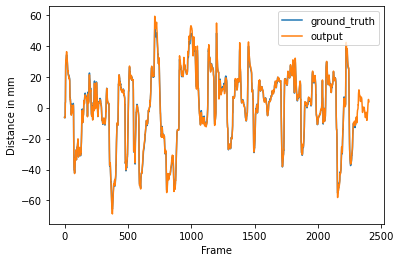

In [60]:
xpoints = np.array(np.arange(len(decoded_test_data)))
# ypoints = np.array(decoded_test_data[1500])

xpoints2 = np.array(np.arange(len(test_data)))
# ypoints2 = np.array(test_data[1500])


plt.plot(xpoints, ypoints, label = 'ground_truth')
plt.plot(xpoints2, ypoints2, label = 'output')
plt.legend(loc="upper right")
plt.xlabel("Frame")
plt.ylabel("Distance in mm")
plt.show()

In [61]:
ypoints = []
for arr in decoded_test_data:
    ypoints.append(arr[98])
ypoints

[-45.54861964086865,
 -45.64079150061884,
 -45.5931170860987,
 -45.81241816980404,
 -46.17581422732599,
 -46.059674442859375,
 -42.15615765518834,
 -42.40303935775471,
 -41.175555047961765,
 -41.0299189841334,
 -40.23961347389307,
 -38.85889619921187,
 -35.65755536559354,
 -34.023064291349,
 -33.57659690809959,
 -33.863862660383504,
 -29.523295879542292,
 -29.529866916120156,
 -28.13146647442669,
 -28.569663111950852,
 -28.302053901612403,
 -27.64266192391013,
 -25.419404519872685,
 -23.307615184542662,
 -19.91952258272689,
 -17.88272025266029,
 -18.212887321233524,
 -18.15732628684672,
 -19.003378587859203,
 -19.640391125490098,
 -20.595633781754522,
 -21.38489527231056,
 -22.346342803389145,
 -22.314773391035416,
 -22.44056314327772,
 -22.39355473801985,
 -22.65470490071234,
 -22.67588667075599,
 -23.06381910193285,
 -22.532566446307882,
 -22.485045491023783,
 -24.200337511286477,
 -35.163908153755344,
 -39.79016863747117,
 -43.60792254290118,
 -47.47510599314248,
 -50.42339159099262

In [62]:
ypoints2 = []
for arr in test_data:
    ypoints2.append(arr[98])
ypoints2

[-44.2,
 -44.4,
 -44.2,
 -44.2,
 -44.5,
 -44.5,
 -44.0,
 -44.1,
 -41.7,
 -41.2,
 -40.6,
 -39.5,
 -36.7,
 -35.9,
 -35.5,
 -34.5,
 -29.8,
 -29.7,
 -28.1,
 -28.3,
 -28.7,
 -28.9,
 -26.8,
 -23.3,
 -18.9,
 -16.5,
 -16.5,
 -16.5,
 -17.0,
 -17.5,
 -18.4,
 -19.3,
 -20.3,
 -20.0,
 -20.2,
 -20.5,
 -20.9,
 -20.7,
 -21.5,
 -21.7,
 -23.2,
 -25.1,
 -34.5,
 -39.3,
 -43.8,
 -47.4,
 -51.5,
 -51.3,
 -54.4,
 -56.3,
 -58.0,
 -58.0,
 -53.7,
 -53.2,
 -54.6,
 -56.7,
 -56.6,
 -56.6,
 -51.8,
 -51.0,
 -51.3,
 -51.7,
 -51.3,
 -49.6,
 -49.0,
 -49.7,
 -52.6,
 -52.6,
 -53.5,
 -53.1,
 -52.7,
 -52.8,
 -49.8,
 -48.0,
 -47.1,
 -45.1,
 -39.5,
 -39.4,
 -36.7,
 -36.7,
 -37.3,
 -37.9,
 -39.2,
 -39.1,
 -38.8,
 -38.2,
 -35.9,
 -35.9,
 -28.5,
 -24.0,
 -20.2,
 -17.4,
 -19.9,
 -23.7,
 -27.4,
 -29.6,
 -30.0,
 -29.9,
 -31.0,
 -30.6,
 -31.1,
 -31.4,
 -34.0,
 -36.0,
 -37.8,
 -38.8,
 -38.7,
 -37.9,
 -38.9,
 -40.8,
 -42.1,
 -43.8,
 -45.6,
 -45.1,
 -45.8,
 -46.5,
 -47.1,
 -46.6,
 -44.3,
 -42.6,
 -42.6,
 -42.1,
 -39.2,
 -37.6,
 -37.2,


Text(0.5, 0, 'Frame')

Text(0, 0.5, 'Distance in mm')

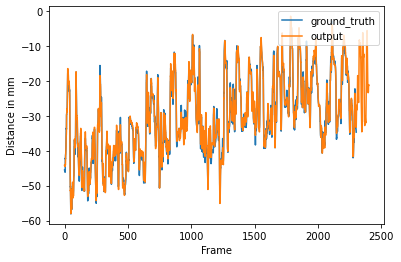

In [63]:
xpoints = np.array(np.arange(len(decoded_test_data)))
# ypoints = np.array(decoded_test_data[1500])

xpoints2 = np.array(np.arange(len(test_data)))
# ypoints2 = np.array(test_data[1500])


plt.plot(xpoints, ypoints, label = 'ground_truth')
plt.plot(xpoints2, ypoints2, label = 'output')
plt.legend(loc="upper right")
plt.xlabel("Frame")
plt.ylabel("Distance in mm")
plt.show()

In [64]:
ypoints = []
for arr in decoded_test_data:
    ypoints.append(arr[166])
ypoints

[444.4528410064566,
 444.55529961982427,
 444.1621507117983,
 444.247549206252,
 443.5265399715279,
 436.97197886268987,
 425.97103021948817,
 426.4504037852551,
 421.6679167710491,
 423.5320708942008,
 423.23766612364534,
 422.8909868055251,
 420.7504690248139,
 416.7398297505768,
 417.6669666589715,
 423.27957725020286,
 422.9737412050143,
 422.6947895853042,
 424.0986418647898,
 425.4897668933247,
 423.492864784003,
 420.77209106549583,
 421.33238088062046,
 428.47281559817895,
 428.83151492039775,
 434.68536426040447,
 436.0935859872937,
 431.3663182321086,
 435.6731230116353,
 437.2933458731697,
 438.17283905813156,
 437.13274856239286,
 437.3666186156883,
 438.89281715168636,
 437.39967366021324,
 434.8316628674733,
 433.9348414030457,
 435.09861456852303,
 432.1766089686416,
 432.8575526758439,
 431.45594823622184,
 430.892180580925,
 436.5676289309808,
 432.17556665411587,
 427.6720913829182,
 426.732157523112,
 425.82384000518783,
 424.88749723217575,
 429.95196871737215,
 434

In [65]:
ypoints2 = []
for arr in test_data:
    ypoints2.append(arr[166])
ypoints2

[443.1,
 443.1,
 442.3,
 442.4,
 442.1,
 436.4,
 427.4,
 428.6,
 423.7,
 426.3,
 426.6,
 426.5,
 423.6,
 419.8,
 421.2,
 426.4,
 425.5,
 425.1,
 426.1,
 427.3,
 425.8,
 423.4,
 422.0,
 430.5,
 428.4,
 435.5,
 437.0,
 431.4,
 437.2,
 438.1,
 439.2,
 439.0,
 439.0,
 439.6,
 437.9,
 436.0,
 434.8,
 435.6,
 433.6,
 434.3,
 433.2,
 432.2,
 437.5,
 433.0,
 428.3,
 427.3,
 423.9,
 422.3,
 428.9,
 434.9,
 438.6,
 436.0,
 430.8,
 425.8,
 426.3,
 433.9,
 435.7,
 435.7,
 433.8,
 433.6,
 433.8,
 433.6,
 435.9,
 436.5,
 436.9,
 437.1,
 436.7,
 436.4,
 429.9,
 430.7,
 430.6,
 433.7,
 421.7,
 417.1,
 418.4,
 417.3,
 415.3,
 414.8,
 416.9,
 416.1,
 416.6,
 419.1,
 423.8,
 420.2,
 414.0,
 415.0,
 421.3,
 421.8,
 427.1,
 428.0,
 430.6,
 424.6,
 425.4,
 426.2,
 427.6,
 426.6,
 421.7,
 421.2,
 416.0,
 417.1,
 420.4,
 425.1,
 424.4,
 425.1,
 427.1,
 425.3,
 424.0,
 425.0,
 422.5,
 418.9,
 418.6,
 420.6,
 434.1,
 429.7,
 429.2,
 432.3,
 436.0,
 434.4,
 433.1,
 428.4,
 431.1,
 430.5,
 430.9,
 429.9,
 428.0,


Text(0.5, 0, 'Frame')

Text(0, 0.5, 'Distance in mm')

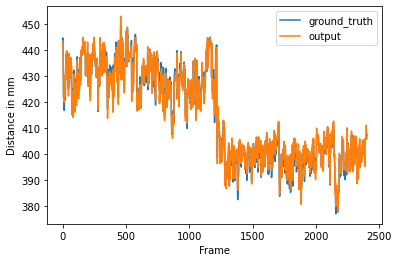

In [66]:
xpoints = np.array(np.arange(len(decoded_test_data)))
# ypoints = np.array(decoded_test_data[1500])

xpoints2 = np.array(np.arange(len(test_data)))
# ypoints2 = np.array(test_data[1500])


plt.plot(xpoints, ypoints, label = 'ground_truth')
plt.plot(xpoints2, ypoints2, label = 'output')
plt.legend(loc="upper right")
plt.xlabel("Frame")
plt.ylabel("Distance in mm")
plt.show()

# ===================================

In [ ]:
Y_train_encoded = np.load(DATA_DIR + '/180' + '/Y_train_encoded.npy')

In [ ]:
Y_train_encoded
Y_train_encoded.shape
Y_train_encoded[0]

# For checking AU AE performance

## Comparing the results for non-normalized data(after reconstruction)

In [18]:
encoded_test_data
encoded_test_data.shape

array([[ 0.02313169,  0.07923   , -0.04096149, ..., -0.21727008,
        -0.09205193, -0.07830894],
       [ 0.03054189,  0.06489335, -0.05195136, ..., -0.20429018,
        -0.08963775, -0.06704388],
       [ 0.03185716,  0.0605647 , -0.05313628, ..., -0.21805497,
        -0.09691567, -0.07691257],
       ...,
       [ 0.03370444,  0.02809475,  0.03422676, ..., -0.0084078 ,
        -0.00355579, -0.00051147],
       [ 0.02655628,  0.04750746,  0.01726659, ..., -0.03253075,
        -0.00946075,  0.04512281],
       [-0.02470029,  0.0425222 ,  0.00257837, ..., -0.05783566,
        -0.01788435,  0.07949301]], dtype=float32)

(2304, 8)

In [19]:
test_normalized_data
test_normalized_data.shape

array([[-0.09634589, -0.04413495, -0.06438226, ..., -0.17160669,
        -0.16580738, -0.06601604],
       [-0.09634589, -0.04413495, -0.06438226, ..., -0.17160669,
        -0.16580738, -0.06601604],
       [-0.09634589, -0.04413495, -0.06438226, ..., -0.17160669,
        -0.16580738, -0.06601604],
       ...,
       [-0.09634589, -0.04413495,  0.09364883, ..., -0.06489938,
         0.12492744,  0.02262662],
       [-0.09634589, -0.04413495,  0.10142085, ..., -0.0618506 ,
         0.08658878, -0.01615454],
       [-0.09634589, -0.04413495,  0.11955557, ..., -0.06489938,
         0.10256322, -0.03554513]])

(2404, 17)

In [20]:
decoded_test_data= decode(nn, encoded_test_data)
decoded_test_data.shape
decoded_test_data[10:20]

Decoding ...
reconstructed: [[0.21946634 0.16576454 0.29144285 ... 0.6185432  0.44275058 0.13488538]
 [0.2451104  0.17306301 0.29965686 ... 0.61805894 0.4651141  0.14704969]
 [0.22422385 0.19412005 0.28668158 ... 0.6233912  0.45434132 0.13004573]
 ...
 [0.59282404 0.15520009 0.1992474  ... 0.52032322 0.54724619 0.2096378 ]
 [0.5602391  0.15143388 0.17017224 ... 0.52337622 0.52026375 0.13566381]
 [0.45921323 0.14054817 0.17274927 ... 0.53073567 0.47076211 0.1014541 ]]


(2304, 17)

array([[ 0.43892909,  0.23023823,  0.28508706,  0.08279628,  0.31204878,
         0.28287922,  0.10672262,  0.93311395,  0.41712541,  0.50859446,
         0.16536328,  0.56813833,  0.13964235,  0.17313331,  0.57193921,
         0.57913172,  0.31706247],
       [ 0.52217788,  0.27851735,  0.2863037 ,  0.07246638,  0.31567566,
         0.3269375 ,  0.0955717 ,  0.91478339,  0.44032364,  0.48896189,
         0.12259052,  0.60059234,  0.15721741,  0.18485327,  0.57030612,
         0.63704834,  0.3533434 ],
       [ 0.49695559,  0.36253839,  0.36675277, -0.01460823,  0.33477248,
         0.40921228,  0.03637316,  0.80246625,  0.46451425,  0.47013184,
         0.06173391,  0.62881095,  0.1434684 ,  0.09743792,  0.61326467,
         0.69489459,  0.46993159],
       [ 0.45503803,  0.38968464,  0.39676185, -0.04580948,  0.34104285,
         0.42689102,  0.01767422,  0.75750579,  0.47179762,  0.47135528,
         0.04920585,  0.61093979,  0.13058696,  0.05425313,  0.63132789,
         0.69288137

In [21]:
before_encoding = convert_back_to_AU(test_normalized_data, max_val, mean_pose)
before_encoding[10:20]

array([[1.53, 0.07, 0.  , 0.  , 0.59, 0.74, 0.  , 1.42, 0.52, 0.  , 0.  ,
        0.28, 0.  , 0.  , 0.37, 0.74, 0.85],
       [1.49, 0.11, 0.  , 0.  , 0.56, 0.6 , 0.  , 1.63, 0.56, 0.  , 0.  ,
        0.12, 0.  , 0.  , 0.84, 0.96, 0.92],
       [1.18, 0.13, 0.  , 0.  , 0.89, 1.15, 0.04, 2.31, 0.79, 0.1 , 0.  ,
        0.  , 0.  , 0.  , 1.61, 1.13, 0.83],
       [0.98, 0.03, 0.  , 0.  , 1.05, 1.34, 0.08, 2.59, 0.94, 0.19, 0.  ,
        0.  , 0.  , 0.  , 1.85, 1.1 , 0.86],
       [1.12, 0.04, 0.  , 0.  , 1.08, 1.08, 0.11, 2.67, 1.09, 0.45, 0.  ,
        0.  , 0.  , 0.  , 1.66, 1.02, 0.64],
       [1.34, 0.08, 0.  , 0.  , 1.08, 0.96, 0.1 , 2.56, 1.12, 0.51, 0.  ,
        0.  , 0.  , 0.  , 1.3 , 0.86, 0.54],
       [1.39, 0.03, 0.  , 0.  , 1.09, 0.85, 0.03, 2.45, 1.05, 0.48, 0.  ,
        0.  , 0.04, 0.  , 1.  , 0.68, 0.82],
       [1.42, 0.  , 0.  , 0.  , 1.07, 0.96, 0.  , 2.49, 1.02, 0.5 , 0.  ,
        0.  , 0.09, 0.  , 0.84, 0.69, 1.05],
       [1.49, 0.  , 0.  , 0.  , 0.93, 1.14, 0.  

In [22]:
Y_test = np.load('data' + '/Y_test.npy')
Y_test[10:20]

array([[1.53, 0.07, 0.  , 0.  , 0.59, 0.74, 0.  , 1.42, 0.52, 0.  , 0.  ,
        0.28, 0.  , 0.  , 0.37, 0.74, 0.85],
       [1.49, 0.11, 0.  , 0.  , 0.56, 0.6 , 0.  , 1.63, 0.56, 0.  , 0.  ,
        0.12, 0.  , 0.  , 0.84, 0.96, 0.92],
       [1.18, 0.13, 0.  , 0.  , 0.89, 1.15, 0.04, 2.31, 0.79, 0.1 , 0.  ,
        0.  , 0.  , 0.  , 1.61, 1.13, 0.83],
       [0.98, 0.03, 0.  , 0.  , 1.05, 1.34, 0.08, 2.59, 0.94, 0.19, 0.  ,
        0.  , 0.  , 0.  , 1.85, 1.1 , 0.86],
       [1.12, 0.04, 0.  , 0.  , 1.08, 1.08, 0.11, 2.67, 1.09, 0.45, 0.  ,
        0.  , 0.  , 0.  , 1.66, 1.02, 0.64],
       [1.34, 0.08, 0.  , 0.  , 1.08, 0.96, 0.1 , 2.56, 1.12, 0.51, 0.  ,
        0.  , 0.  , 0.  , 1.3 , 0.86, 0.54],
       [1.39, 0.03, 0.  , 0.  , 1.09, 0.85, 0.03, 2.45, 1.05, 0.48, 0.  ,
        0.  , 0.04, 0.  , 1.  , 0.68, 0.82],
       [1.42, 0.  , 0.  , 0.  , 1.07, 0.96, 0.  , 2.49, 1.02, 0.5 , 0.  ,
        0.  , 0.09, 0.  , 0.84, 0.69, 1.05],
       [1.49, 0.  , 0.  , 0.  , 0.93, 1.14, 0.  

In [23]:
def convert_back_to_AU(sequence, max_val, mean_pose):
    '''
    Convert back from the normalized values between -1 and 1 to original AU
    and unroll them into the sequence

    Args:
        sequence: sequence of the normalized values
        max_val: maximal value in the dataset
        mean_pose: mean value in the dataset

    Return:
        AU value corresponding to the batch
    '''

    # Convert it back from the [-1,1] to original values
#     reconstructed = np.multiply(sequence, max_val[np.newaxis, :] + 1e-15)
    reconstructed = np.multiply(sequence, max_val[np.newaxis, :] + 1e-8)
    
    # Add the mean pose back
    reconstructed = reconstructed + mean_pose[np.newaxis, :]

    # Unroll batches into the sequence
    reconstructed = reconstructed.reshape(-1, reconstructed.shape[-1])
    return reconstructed

In [24]:
decoded_test_data, before_encoding

(array([[0.21946634, 0.16576454, 0.29144285, ..., 0.6185432 , 0.44275058,
         0.13488538],
        [0.2451104 , 0.17306301, 0.29965686, ..., 0.61805894, 0.4651141 ,
         0.14704969],
        [0.22422385, 0.19412005, 0.28668158, ..., 0.6233912 , 0.45434132,
         0.13004573],
        ...,
        [0.59282404, 0.15520009, 0.1992474 , ..., 0.52032322, 0.54724619,
         0.2096378 ],
        [0.5602391 , 0.15143388, 0.17017224, ..., 0.52337622, 0.52026375,
         0.13566381],
        [0.45921323, 0.14054817, 0.17274927, ..., 0.53073567, 0.47076211,
         0.1014541 ]]),
 array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.61, ..., 0.35, 0.91, 0.32],
        [0.  , 0.  , 0.64, ..., 0.36, 0.79, 0.18],
        [0.  , 0.  , 0.71, ..., 0.35, 0.84, 0.11]]))

In [25]:
import pandas as pd
columns = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r']
decoded_test_data_df = pd.DataFrame(decoded_test_data, columns = columns)
decoded_test_data_df['is_predict'] = 1

In [26]:
before_encoding_df = pd.DataFrame(before_encoding, columns = columns)
before_encoding_df['is_predict'] = 0

In [27]:
combined = decoded_test_data_df.append(before_encoding_df, ignore_index=True)
combined

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,is_predict
0,0.219466,0.165765,0.291443,0.044821,0.293166,0.298016,0.078721,0.825095,0.396325,0.324327,0.121130,0.748015,0.015713,0.046720,0.618543,0.442751,0.134885,1
1,0.245110,0.173063,0.299657,0.052370,0.296531,0.311449,0.083249,0.829760,0.387362,0.338500,0.123008,0.742303,0.032658,0.052603,0.618059,0.465114,0.147050,1
2,0.224224,0.194120,0.286682,0.046810,0.291491,0.301003,0.079256,0.814549,0.387521,0.328008,0.114907,0.760847,0.023743,0.041153,0.623391,0.454341,0.130046,1
3,0.214004,0.200733,0.279245,0.045506,0.288637,0.292641,0.078218,0.807339,0.388724,0.322139,0.112095,0.772050,0.018403,0.036346,0.625541,0.447309,0.120955,1
4,0.308634,0.244914,0.260337,0.090912,0.283475,0.304974,0.102665,0.774101,0.409979,0.306655,0.077981,0.851166,0.037092,0.055791,0.619927,0.514297,0.105531,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,0.000000,0.000000,0.620000,0.000000,0.020000,0.000000,0.090000,0.670000,0.000000,0.760000,0.100000,0.530000,0.000000,0.000000,0.000000,0.900000,1.440000,0
4704,0.000000,0.000000,0.620000,0.000000,0.000000,0.000000,0.130000,0.820000,0.000000,0.780000,0.090000,0.580000,0.000000,0.000000,0.230000,1.010000,0.530000,0
4705,0.000000,0.000000,0.610000,0.000000,0.000000,0.000000,0.120000,0.790000,0.000000,0.690000,0.050000,0.580000,0.000000,0.000000,0.350000,0.910000,0.320000,0
4706,0.000000,0.000000,0.640000,0.000000,0.000000,0.000000,0.060000,0.710000,0.000000,0.590000,0.150000,0.580000,0.010000,0.000000,0.360000,0.790000,0.180000,0


List of AU columns: Index(['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r'],
      dtype='object')


<AxesSubplot:ylabel='AU01_r'>

[Text(0.5, 1.0, 'AU01_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU02_r'>

[Text(0.5, 1.0, 'AU02_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU04_r'>

[Text(0.5, 1.0, 'AU04_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU05_r'>

[Text(0.5, 1.0, 'AU05_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU06_r'>

[Text(0.5, 1.0, 'AU06_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU07_r'>

[Text(0.5, 1.0, 'AU07_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU09_r'>

[Text(0.5, 1.0, 'AU09_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU10_r'>

[Text(0.5, 1.0, 'AU10_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU12_r'>

[Text(0.5, 1.0, 'AU12_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU14_r'>

[Text(0.5, 1.0, 'AU14_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU15_r'>

[Text(0.5, 1.0, 'AU15_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU17_r'>

[Text(0.5, 1.0, 'AU17_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU20_r'>

[Text(0.5, 1.0, 'AU20_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU23_r'>

[Text(0.5, 1.0, 'AU23_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU25_r'>

[Text(0.5, 1.0, 'AU25_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU26_r'>

[Text(0.5, 1.0, 'AU26_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU45_r'>

[Text(0.5, 1.0, 'AU45_r'), Text(0, 0.5, 'Intensity')]

Text(0.5, 1.02, 'AU intensity predictions by time for each face')

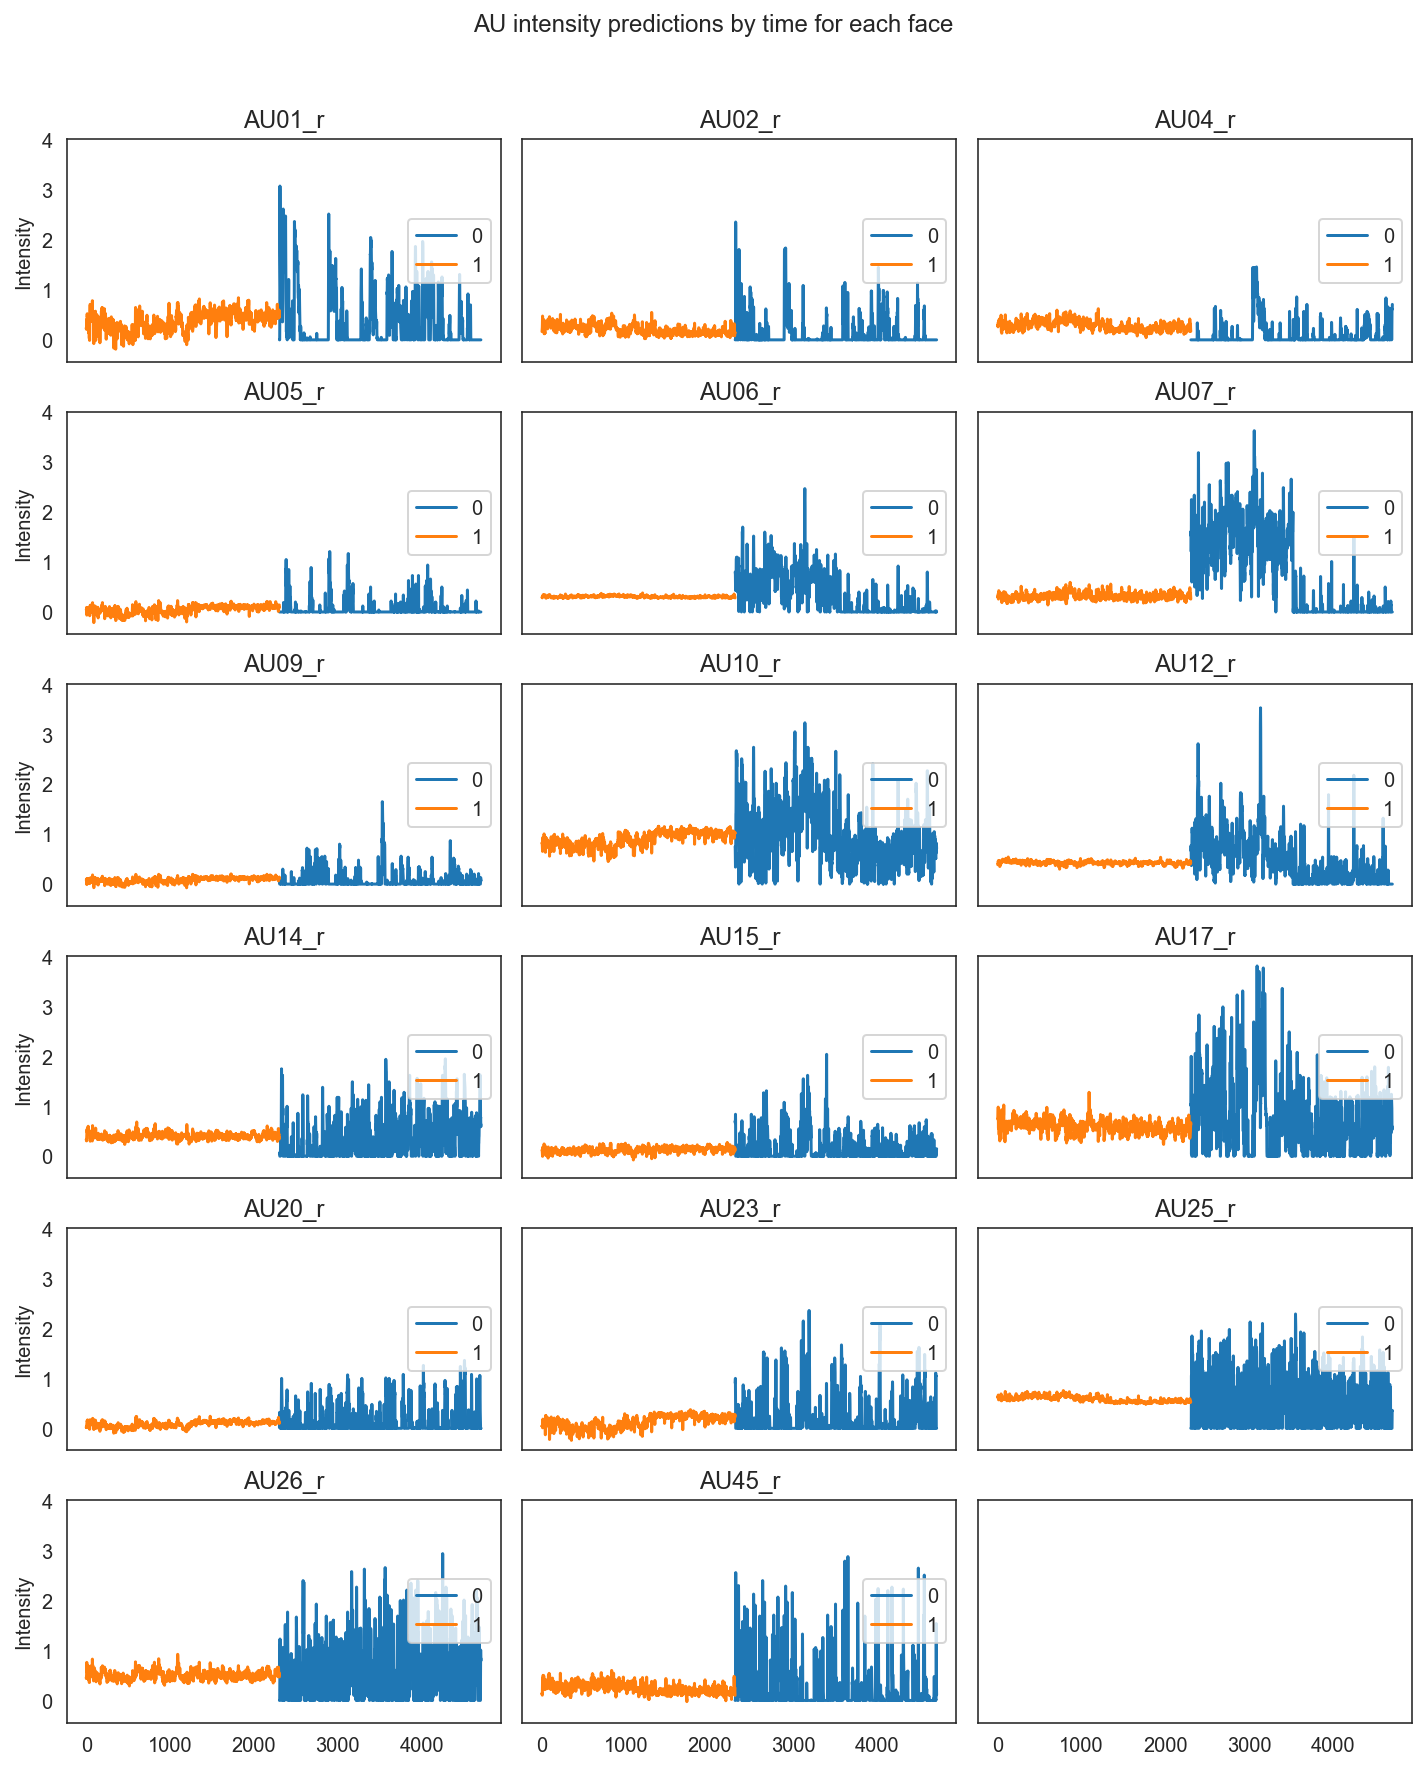

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd, seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt 
import re

# Threshold data by 80%
# df_clean = df[df.confidence>=.80]
# Plot all Action Unit time series. 
au_regex_pat = re.compile(r'^AU[0-9]+_r$')
au_columns = combined.columns[combined.columns.str.contains(au_regex_pat)]
print("List of AU columns:", au_columns)
f,axes = plt.subplots(6, 3, figsize=(10,12), sharex=True, sharey=True)
axes = axes.flatten()
for au_ix, au_col in enumerate(au_columns):
    sns.lineplot(x=combined.index, y=au_col, hue='is_predict', data=combined, ax=axes[au_ix])
    axes[au_ix].set(title=au_col, ylabel='Intensity')
    axes[au_ix].legend(loc=5)
plt.suptitle("AU intensity predictions by time for each face", y=1.02)
plt.tight_layout()

# Let's compare how much AU12 (smiling) activity occurs at similar times across people.
# df_clean.pivot(index='frame', columns='face_id', values='AU12_r').corr()

## Comparing the results for normalized data(no reconstruction of the original values)

In [29]:
def decode(nn, represent_vec): # no reconstruction for checking purposes
    """ Decoding a representation from AE (AutoEncoder)

      Args:
          nn:              trained AutoEncoder
          represent_vec:   input sequence to be encoded

      Returns:
          output_seq:  vector of encoding
    """

    print("Decoding ...")

    with nn.session.graph.as_default() as sess:

        # Obtain important constants

        sess = nn.session
        mean_pose = nn.mean_pose
        max_val = nn.max_val

        #                    GET THE DATA

        # Check if we can cut sequence into the chunks of length ae.sequence_length
        if represent_vec.shape[0] < nn.sequence_length:
            mupliplication_factor = int(nn.batch_size * nn.sequence_length /
                                        represent_vec.shape[0]) + 1

            # Pad the sequence with itself in order to fill the sequence completely
            represent_vec = np.tile(represent_vec, (mupliplication_factor, 1))
            print("Test sequence was way too short, so we padded it with itself!")

        # Split it into chunks
        all_chunks = represent_vec

        if all_chunks.shape[0] < nn.batch_size:
            mupliplication_factor = int(nn.batch_size / all_chunks.shape[0]) + 1

            # Pad the sequence with itself in order to fill the batch completely
            all_chunks = np.tile(all_chunks, (mupliplication_factor, 1))

        # Batch those chunks
        batches = np.array([all_chunks[i:i + nn.batch_size, :]
                            for i in range(0, len(all_chunks) - nn.batch_size + 1, nn.batch_size)])

        numb_of_batches = batches.shape[0]

        #                    RUN THE NETWORK

        output_batches = np.array([])

        # Go over all batches one by one
        for batch_numb in range(numb_of_batches):
            output_batch = sess.run([nn._decode],
                                    feed_dict={nn._representation: batches[batch_numb]})
            output_batches = np.append(output_batches, output_batch, axis=0) \
                if output_batches.size else np.array(output_batch)

        # Postprocess...
        output_vec = np.reshape(output_batches, (-1, FLAGS.chunk_length * FLAGS.frame_size))
        return output_vec


test_normalized_data
decoded_test_data= decode(nn, encoded_test_data)

array([[-0.09634589, -0.04413495, -0.06438226, ..., -0.17160669,
        -0.16580738, -0.06601604],
       [-0.09634589, -0.04413495, -0.06438226, ..., -0.17160669,
        -0.16580738, -0.06601604],
       [-0.09634589, -0.04413495, -0.06438226, ..., -0.17160669,
        -0.16580738, -0.06601604],
       ...,
       [-0.09634589, -0.04413495,  0.09364883, ..., -0.06489938,
         0.12492744,  0.02262662],
       [-0.09634589, -0.04413495,  0.10142085, ..., -0.0618506 ,
         0.08658878, -0.01615454],
       [-0.09634589, -0.04413495,  0.11955557, ..., -0.06489938,
         0.10256322, -0.03554513]])

Decoding ...


In [30]:
decoded_test_data

array([[-0.05236466, -0.00620256,  0.01112107, ...,  0.01697355,
        -0.02435352, -0.02865167],
       [-0.04722557, -0.00453243,  0.01324905, ...,  0.01682591,
        -0.01720863, -0.02528205],
       [-0.05141125,  0.00028611,  0.00988758, ...,  0.0184516 ,
        -0.02065041, -0.02999229],
       ...,
       [ 0.02245652, -0.00862006, -0.01276376, ..., -0.01297157,
         0.00903166, -0.00794463],
       [ 0.01592647, -0.00948189, -0.02029618, ..., -0.01204077,
         0.00041107, -0.02843604],
       [-0.00431919, -0.0119729 , -0.01962856, ..., -0.00979704,
        -0.01540415, -0.03791241]], dtype=float32)

In [31]:
columns = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r']
decoded_test_data_df = pd.DataFrame(decoded_test_data, columns = columns)
decoded_test_data_df['is_predict'] = 1

In [32]:
test_normalized_data_df = pd.DataFrame(test_normalized_data, columns = columns)
test_normalized_data_df['is_predict'] = 0


In [33]:
combined = decoded_test_data_df.append(test_normalized_data_df, ignore_index=True)
combined

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,is_predict
0,-0.052365,-0.006203,0.011121,-0.015790,-0.004150,-0.006484,-0.013840,-0.041400,-0.004403,-0.033759,-0.007699,0.044567,-0.043141,-0.046261,0.016974,-0.024354,-0.028652,1
1,-0.047226,-0.004532,0.013249,-0.012374,-0.002917,-0.002545,-0.011325,-0.039974,-0.006517,-0.028308,-0.006661,0.043083,-0.036623,-0.044300,0.016826,-0.017209,-0.025282,1
2,-0.051411,0.000286,0.009888,-0.014890,-0.004763,-0.005609,-0.013543,-0.044625,-0.006480,-0.032343,-0.011136,0.047899,-0.040052,-0.048117,0.018452,-0.020650,-0.029992,1
3,-0.053459,0.001799,0.007961,-0.015480,-0.005809,-0.008060,-0.014120,-0.046830,-0.006196,-0.034601,-0.012690,0.050809,-0.042106,-0.049719,0.019107,-0.022897,-0.032511,1
4,-0.034495,0.011909,0.003062,0.005066,-0.007699,-0.004444,-0.000538,-0.056995,-0.001183,-0.040556,-0.031538,0.071359,-0.034918,-0.043238,0.017396,-0.001495,-0.036783,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,-0.096346,-0.044135,0.096240,-0.036071,-0.104210,-0.093879,-0.007574,-0.088830,-0.097876,0.133807,-0.019373,-0.012061,-0.049184,-0.061835,-0.171607,0.121733,0.332876,0
4704,-0.096346,-0.044135,0.096240,-0.036071,-0.111536,-0.093879,0.014648,-0.042958,-0.097876,0.141500,-0.024897,0.000926,-0.049184,-0.061835,-0.101485,0.156876,0.080798,0
4705,-0.096346,-0.044135,0.093649,-0.036071,-0.111536,-0.093879,0.009092,-0.052133,-0.097876,0.106884,-0.046997,0.000926,-0.049184,-0.061835,-0.064899,0.124927,0.022627,0
4706,-0.096346,-0.044135,0.101421,-0.036071,-0.111536,-0.093879,-0.024241,-0.076597,-0.097876,0.068423,0.008252,0.000926,-0.045338,-0.061835,-0.061851,0.086589,-0.016155,0


List of AU columns: Index(['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r'],
      dtype='object')


<AxesSubplot:ylabel='AU01_r'>

[Text(0.5, 1.0, 'AU01_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU02_r'>

[Text(0.5, 1.0, 'AU02_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU04_r'>

[Text(0.5, 1.0, 'AU04_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU05_r'>

[Text(0.5, 1.0, 'AU05_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU06_r'>

[Text(0.5, 1.0, 'AU06_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU07_r'>

[Text(0.5, 1.0, 'AU07_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU09_r'>

[Text(0.5, 1.0, 'AU09_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU10_r'>

[Text(0.5, 1.0, 'AU10_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU12_r'>

[Text(0.5, 1.0, 'AU12_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU14_r'>

[Text(0.5, 1.0, 'AU14_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU15_r'>

[Text(0.5, 1.0, 'AU15_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU17_r'>

[Text(0.5, 1.0, 'AU17_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU20_r'>

[Text(0.5, 1.0, 'AU20_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU23_r'>

[Text(0.5, 1.0, 'AU23_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU25_r'>

[Text(0.5, 1.0, 'AU25_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU26_r'>

[Text(0.5, 1.0, 'AU26_r'), Text(0, 0.5, 'Intensity')]

<AxesSubplot:ylabel='AU45_r'>

[Text(0.5, 1.0, 'AU45_r'), Text(0, 0.5, 'Intensity')]

Text(0.5, 1.02, 'AU intensity predictions by time for each face')

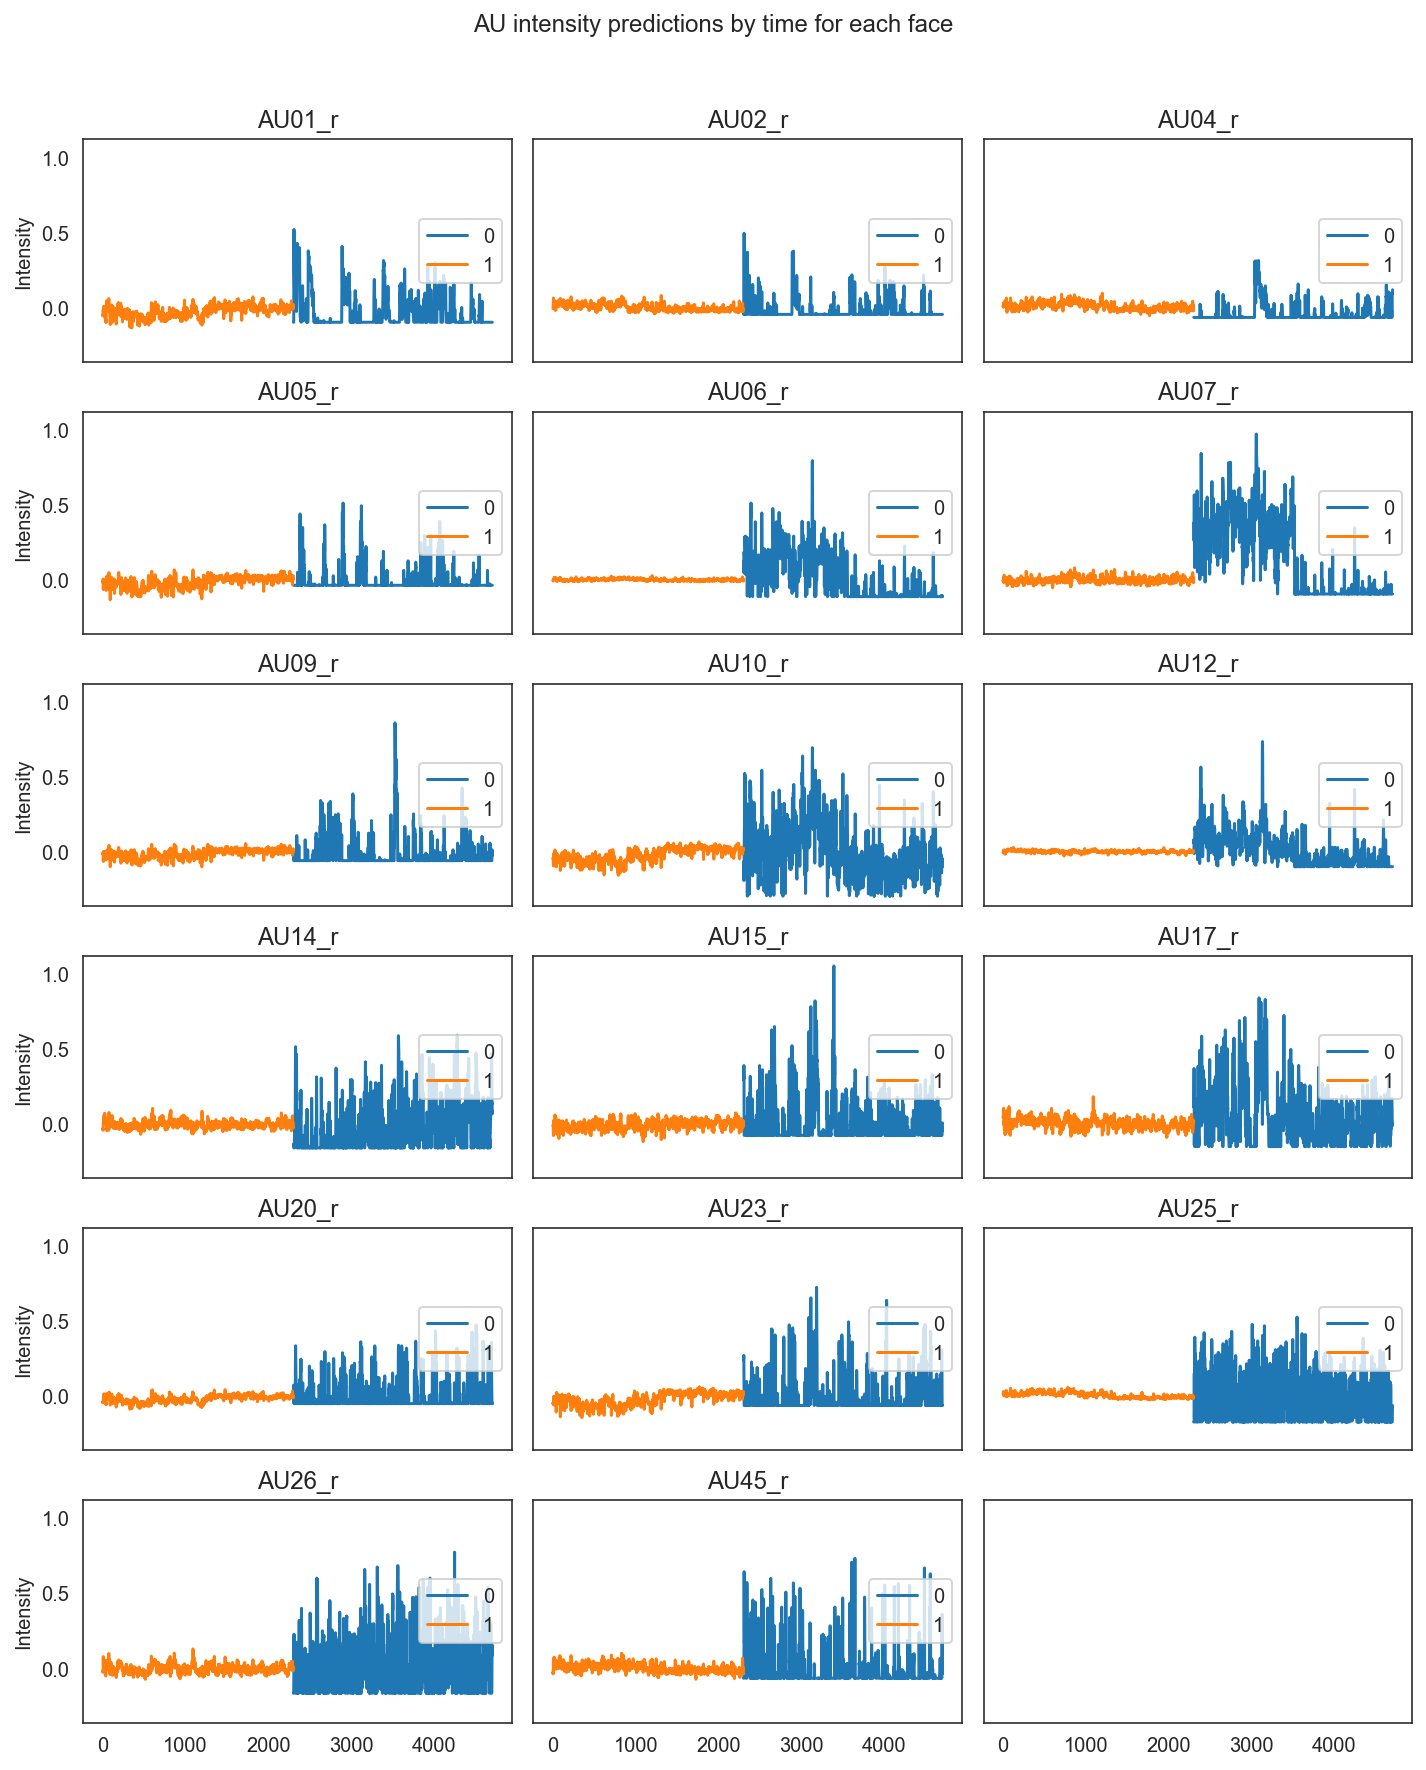

In [34]:
# Threshold data by 80%
# df_clean = df[df.confidence>=.80]
# Plot all Action Unit time series. 
au_regex_pat = re.compile(r'^AU[0-9]+_r$')
au_columns = combined.columns[combined.columns.str.contains(au_regex_pat)]
print("List of AU columns:", au_columns)
f,axes = plt.subplots(6, 3, figsize=(10,12), sharex=True, sharey=True)
axes = axes.flatten()
for au_ix, au_col in enumerate(au_columns):
    sns.lineplot(x=combined.index, y=au_col, hue='is_predict', data=combined, ax=axes[au_ix])
    axes[au_ix].set(title=au_col, ylabel='Intensity')
    axes[au_ix].legend(loc=5)
plt.suptitle("AU intensity predictions by time for each face", y=1.02)
plt.tight_layout()

# Let's compare how much AU12 (smiling) activity occurs at similar times across people.
# df_clean.pivot(index='frame', columns='face_id', values='AU12_r').corr()